<a href="https://colab.research.google.com/github/Nimuar/ME53900_IntroductionToScientificMachineLearning/blob/master/my_submissions/homework-08.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Homework 8


## References

+ Lectures 27-28 (inclusive).


## Instructions

+ Type your name and email in the "Student details" section below.
+ Develop the code and generate the figures you need to solve the problems using this notebook.
+ For the answers that require a mathematical proof or derivation you should type them using latex. If you have never written latex before and you find it exceedingly difficult, we will likely accept handwritten solutions.
+ The total homework points are 100. Please note that the problems are not weighed equally.

In [1]:
MAKE_BOOK_FIGURES=True
import numpy as np
import scipy.stats as st

import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')
import seaborn as sns
sns.set_context("paper")
sns.set_style("ticks")

def set_book_style():
    plt.style.use('seaborn-v0_8-white')
    sns.set_style("ticks")
    sns.set_palette("deep")

    mpl.rcParams.update({
        # Font settings
        'font.family': 'serif',  # For academic publishing
        'font.size': 8,  # As requested, 10pt font
        'axes.labelsize': 8,
        'axes.titlesize': 8,
        'xtick.labelsize': 7,  # Slightly smaller for better readability
        'ytick.labelsize': 7,
        'legend.fontsize': 7,

        # Line and marker settings for consistency
        'axes.linewidth': 0.5,
        'grid.linewidth': 0.5,
        'lines.linewidth': 1.0,
        'lines.markersize': 4,

        # Layout to prevent clipped labels
        'figure.constrained_layout.use': True,

        # Default DPI (will override when saving)
        'figure.dpi': 600,
        'savefig.dpi': 600,

        # Despine - remove top and right spines
        'axes.spines.top': False,
        'axes.spines.right': False,

        # Remove legend frame
        'legend.frameon': False,

        # Additional trim settings
        'figure.autolayout': True,  # Alternative to constrained_layout
        'savefig.bbox': 'tight',    # Trim when saving
        'savefig.pad_inches': 0.1   # Small padding to ensure nothing gets cut off
    })

def set_notebook_style():
    plt.style.use('seaborn-v0_8-white')
    sns.set_style("ticks")
    sns.set_palette("deep")

    mpl.rcParams.update({
        # Font settings - using default sizes
        'font.family': 'serif',
        'axes.labelsize': 10,
        'axes.titlesize': 10,
        'xtick.labelsize': 9,
        'ytick.labelsize': 9,
        'legend.fontsize': 9,

        # Line and marker settings
        'axes.linewidth': 0.5,
        'grid.linewidth': 0.5,
        'lines.linewidth': 1.0,
        'lines.markersize': 4,

        # Layout settings
        'figure.constrained_layout.use': True,

        # Remove only top and right spines
        'axes.spines.top': False,
        'axes.spines.right': False,

        # Remove legend frame
        'legend.frameon': False,

        # Additional settings
        'figure.autolayout': True,
        'savefig.bbox': 'tight',
        'savefig.pad_inches': 0.1
    })

def save_for_book(fig, filename, is_vector=True, **kwargs):
    """
    Save a figure with book-optimized settings.

    Parameters:
    -----------
    fig : matplotlib figure
        The figure to save
    filename : str
        Filename without extension
    is_vector : bool
        If True, saves as vector at 1000 dpi. If False, saves as raster at 600 dpi.
    **kwargs : dict
        Additional kwargs to pass to savefig
    """
    # Set appropriate DPI and format based on figure type
    if is_vector:
        dpi = 1000
        ext = '.pdf'
    else:
        dpi = 600
        ext = '.tif'

    # Save the figure with book settings
    fig.savefig(f"{filename}{ext}", dpi=dpi, **kwargs)

def make_full_width_fig():
    return plt.subplots(figsize=(4.7, 2.9), constrained_layout=True)

def make_half_width_fig():
    return plt.subplots(figsize=(2.35, 1.45), constrained_layout=True)

if MAKE_BOOK_FIGURES:
    set_book_style()
else:
    set_notebook_style()

make_full_width_fig = make_full_width_fig if MAKE_BOOK_FIGURES else lambda: plt.subplots()
make_half_width_fig = make_half_width_fig if MAKE_BOOK_FIGURES else lambda: plt.subplots()

In [2]:
# Run this on Google colab
!pip install pyro-ppl

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 756.0/756.0 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 30.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 26.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 41.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 25.0 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalli

In [3]:
import pyro
import pyro.distributions as dist
from pyro.infer import MCMC, NUTS
import torch

## Student details

+ **First Name:** Kevin
+ **Last Name:** Rivera
+ **Email:** river297@purdue.edu

## Problem 1  - Bayesian Linear regression on steroids

The purpose of this problem is to demonstrate that we have learned enough to do very complicated things.
In the first part, we will do Bayesian linear regression with radial basis functions (RBFs) in which we characterize the posterior of all parameters, including the length-scales of the RBFs.
In the second part, we are going to build a model that has an input-varying noise. Such models are called heteroscedastic models.

We need to write some `pytorch` code to compute the design matrix. This is absolutely necessary so that `pyro` can differentiate through all expressions.

In [4]:
class RadialBasisFunctions(torch.nn.Module):
    """Radial basis functions basis.

    Arguments:
    X   -  The centers of the radial basis functions.
    ell -  The assumed length scale.
    """
    def __init__(self, X, ell):
        super().__init__()
        self.X = X
        self.ell = ell
        self.num_basis = X.shape[0]
    def forward(self, x):
        distances = torch.cdist(x, self.X)
        return torch.exp(-.5 * distances ** 2 / self.ell ** 2)

Here is how you can use them:

In [5]:
# Make the basis
x_centers = torch.linspace(-1, 1, 10).unsqueeze(-1)
ell = 0.2
basis = RadialBasisFunctions(x_centers, ell)

# Some points (need to be N x 1)
x = torch.linspace(-1, 1, 100).unsqueeze(-1)

# Evaluate the basis
Phi = basis(x)

# Here is the shape of Phi
print(Phi.shape)

torch.Size([100, 10])


Here is how they look like:

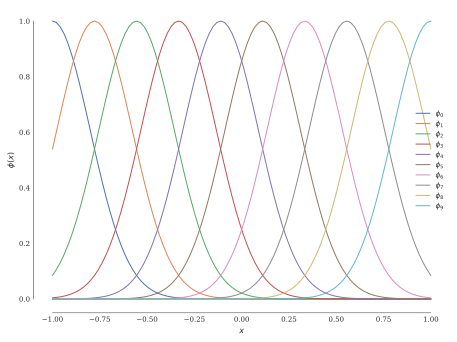

In [6]:
fig, ax = plt.subplots()
for i in range(Phi.shape[1]):
    ax.plot(x, Phi[:, i], label=f"$\phi_{i}$")
ax.set(xlabel="$x$", ylabel="$\phi(x)$")
ax.legend(loc="best", frameon=False)
sns.despine(trim=True);

### Part A - Hierarchical Bayesian linear regression with input-independent noise

We will analyze the motorcycle dataset. The data is loaded below.

In [7]:
url = "https://raw.githubusercontent.com/PredictiveScienceLab/data-analytics-se/master/lecturebook/data/motor.dat"
!curl -O $url

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  2970  100  2970    0     0   5825      0 --:--:-- --:--:-- --:--:--  5823


We will work with the scaled data:

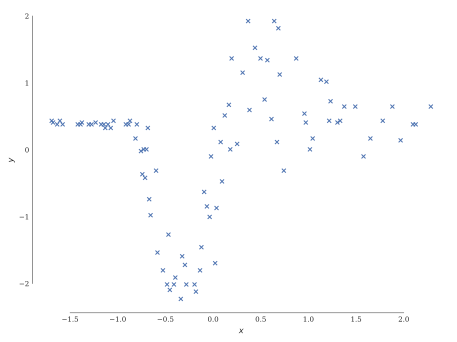

In [8]:
from sklearn.preprocessing import StandardScaler

data = np.loadtxt('motor.dat')
scaler = StandardScaler()
data = scaler.fit_transform(data)
X = torch.tensor(data[:, 0], dtype=torch.float32).unsqueeze(-1)
Y = torch.tensor(data[:, 1], dtype=torch.float32)

fig, ax = plt.subplots()
ax.plot(X, Y, 'x')
ax.set(xlabel="$x$", ylabel="$y$")
sns.despine(trim=True);

### Part A.I

Your goal is to implement the model described below.
We use the radial basis functions (`RadialBasisFunction`) with centers, $x_i$ at $m=50$ equidistant points between the minimum and maximum of the observed inputs:

$$
\phi_i(x;\ell) = \exp \left( - \frac{(x - x_i)^2}{2 \ell^2} \right),
$$

for $i=1,\dots,m$.
We denote the vector of RBFs evaluated at $x$ as $\boldsymbol{\phi}(x;\ell)$.

We are not going to pick the length-scales $\ell$ by hand. Instead, we will put a prior on it:

$$
\ell \sim \text{Exponential}(1).
$$

The corresponding weights have priors:

$$
w_j | \alpha_i \sim N(0, \alpha_j^2),
$$

and its $\alpha_j$ has a prior:

$$
\alpha_j \sim \text{Exponential}(1),
$$

for $j=1,\dots,m$.

Denote our data as:

$$
x_{1:n} = (x_1, \dots, x_n)^T,\;\text{(inputs)},
$$

and

$$
y_{1:n} = (y_1, \dots, y_n)^T,\;\text{(outputs)}.
$$

The likelihood of the data is:

$$
y_i | \mathbf{w}, \sigma \sim N(\mathbf{w}^T \boldsymbol{\phi}(x_i;\ell), \sigma^2),
$$

for $i=1,\dots,n$.

$$
y_n | \ell, \mathbf{w}, \sigma \sim N(\mathbf{w}^T \boldsymbol{\phi}(x_n;\ell), \sigma^2).
$$

Complete the `pyro` implementation of that model:

**Answer:**

In [9]:
def model(X, y, num_centers=50):
    with pyro.plate("centers", num_centers):
        alpha = pyro.sample("alpha", dist.Exponential(1.0))
        # Notice below that dist.Normal needs the standard deviation - not the variance
        # We follow a different convention in the lecture notes
        w = pyro.sample("w", dist.Normal(0.0, alpha))

    # Complete the code assign to ell the correct prior distribution (an Exponential(1)).
    ell = pyro.sample("ell", dist.Exponential(1))
    # Hint: Look at alpha.
    # Complete the code assign to sigma the correct prior distribution (an Exponential(1))
    sigma = pyro.sample("sigma", dist.Exponential(1))

    x_centers = torch.linspace(X.min(), X.max(), num_centers).unsqueeze(-1)
    Phi = RadialBasisFunctions(x_centers, ell)(X)
    with pyro.plate("data", X.shape[0]):
        pyro.sample("y", dist.Normal(Phi @ w, sigma), obs=y)
    # Notice that I'm making the model return all the variables that I have made.
    # This is not essential for characterizing the posterior, but it does reduce redundant code
    # when we are trying to get the posterior predictive.
    return locals()

The graph will help to understand the model:

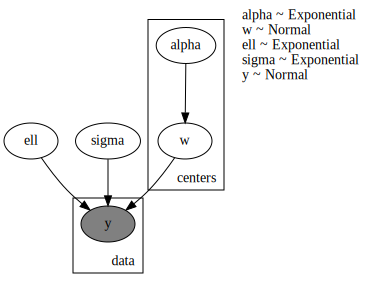

In [10]:
pyro.render_model(model, (X, Y), render_distributions=True)

Use `pyro.infer.autoguide.AutoDiagonalNormal` to make the guide:

In [11]:
guide = pyro.infer.autoguide.AutoDiagonalNormal(model)

We will use variational inference. Here is the training code from the hans-on activity:

In [12]:
def train(model, guide, data, num_iter=5_000):
    """Train a model with a guide.

    Arguments
    ---------
    model    -- The model to train.
    guide    -- The guide to train.
    data     -- The data to train the model with.
    num_iter -- The number of iterations to train.

    Returns
    -------
    elbos -- The ELBOs for each iteration.
    param_store -- The parameters of the model.
    """

    pyro.clear_param_store()

    optimizer = pyro.optim.Adam({"lr": 0.001})

    svi = pyro.infer.SVI(
        model,
        guide,
        optimizer,
        loss=pyro.infer.JitTrace_ELBO()
    )

    elbos = []
    for i in range(num_iter):
        loss = svi.step(*data)
        elbos.append(-loss)
        if i % 1_000 == 0:
            print(f"Iteration: {i} Loss: {loss}")

    return elbos, pyro.get_param_store()

### Part A.II

Train the model for 20,000 iterations. Call the `train()` function we defined above to do it.
Make sure you store the returned elbo values because you will need them later.

**Answer:**

In [19]:
num_iter = 20_000

elbos, params = train(model, guide, (X, Y), num_iter)

Iteration: 0 Loss: 123.11637115478516
Iteration: 1000 Loss: 129.30812072753906
Iteration: 2000 Loss: 126.19368743896484
Iteration: 3000 Loss: 128.94590759277344
Iteration: 4000 Loss: 119.62825012207031
Iteration: 5000 Loss: 119.64585876464844
Iteration: 6000 Loss: 124.40413665771484
Iteration: 7000 Loss: 123.49269104003906
Iteration: 8000 Loss: 138.895263671875
Iteration: 9000 Loss: 120.01420593261719
Iteration: 10000 Loss: 125.56315612792969
Iteration: 11000 Loss: 122.03654479980469
Iteration: 12000 Loss: 132.61378479003906
Iteration: 13000 Loss: 128.6484375
Iteration: 14000 Loss: 123.56893157958984
Iteration: 15000 Loss: 125.04957580566406
Iteration: 16000 Loss: 121.57994079589844
Iteration: 17000 Loss: 132.653564453125
Iteration: 18000 Loss: 123.81429290771484
Iteration: 19000 Loss: 122.93976593017578


### Part A.III

Plot the evolution of the ELBO.

**Answer:**

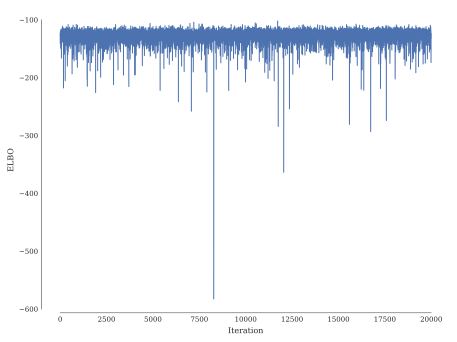

In [20]:
fig, ax = plt.subplots()
ax.plot(torch.arange(num_iter), elbos)
ax.set(xlabel='Iteration', ylabel='ELBO')
sns.despine(trim=True);

### Part A.IV

Take 1,000 posterior samples.

**Answer:**

I'm giving you this one because it is a bit tricky. You need to use the `pyro.infer.Predictive` class to do it. Here is how you can use it:

In [21]:
post_samples = pyro.infer.Predictive(model, guide=guide, num_samples=1000)(X, Y)
# Just modify the call to get the right number of samples

### Part A.V

Plot the histograms of the posteriors of $\ell$, $\sigma$, $\alpha_{10}$ and $w_{10}$.

**Answer:**

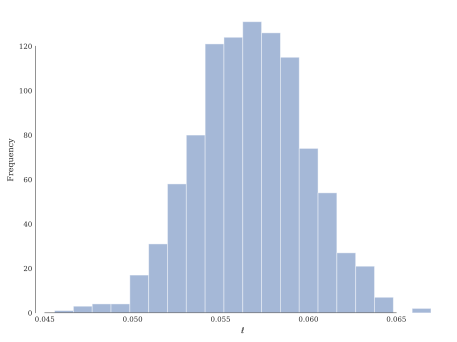

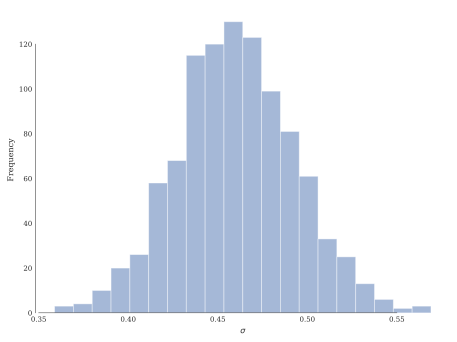

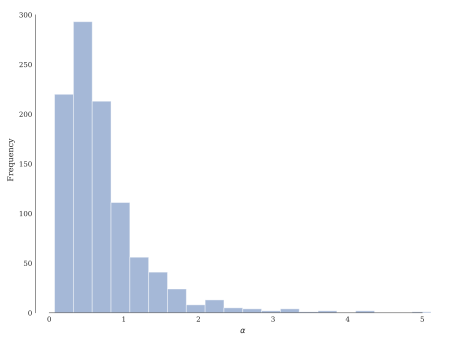

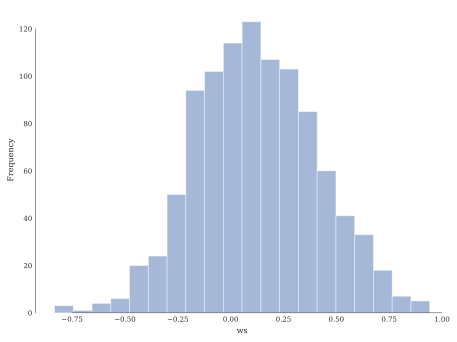

In [32]:
# First, here is how to extract the samples.
ell = post_samples["ell"]
# You can do `post_samples.keys()` to see all the keys.
# But they should correspond to the names of the latent variables in the model.
sigma = post_samples["sigma"]
alphas = post_samples["alpha"]
ws = post_samples["w"]

# Here is the code to make the histogram for the length scale.
fig, ax = plt.subplots()
# **VERY IMPORTANT** - You need to detach the tensor from the computational graph.
# Otherwise, you will get very very strange behavior.
ax.hist(ell.detach().numpy(), bins=20, alpha=.5)
ax.set(xlabel=r"$\ell$", ylabel="Frequency")
sns.despine(trim=True);

fig, ax = plt.subplots()
ax.hist(sigma.detach().numpy(), bins=20, alpha=.5)
ax.set(xlabel=r"$\sigma$", ylabel="Frequency")
sns.despine(trim=True);

fig, ax = plt.subplots()
ax.hist(alphas.detach().numpy()[:, 9], bins=20, alpha=.5) # Selecting the 10th element (index 9)
ax.set(xlabel=r"$\alpha$", ylabel="Frequency")
sns.despine(trim=True);

fig, ax = plt.subplots()
ax.hist(ws.detach().numpy()[:, 9], bins=20, alpha=.5) # Selecting the 10th element (index 9)
ax.set(xlabel=r"ws", ylabel="Frequency")
sns.despine(trim=True);

### Part A.VI

Let's extend them model to make predictions.

**Answer:**

In [33]:
# Again, I'm giving you most of the code here.

def predictive_model(X, y, num_centers=50):
    # First we run the original model get all the variables
    params = model(X, y, num_centers)
    # Here is how you can access the variables
    w = params["w"]
    ell = params["ell"] # Access the length scale
    sigma = params["sigma"] # Access the standard deviation of the measurement noise
    x_centers = torch.linspace(X.min(), X.max(), num_centers).unsqueeze(-1)
    # Access the centers of the radial basis functions
    # Here are the points where we want to make predictions
    xs = torch.linspace(X.min(), X.max(), 100).unsqueeze(-1)
    # Evaluate the basis on the prediction points
    Phi = RadialBasisFunctions(x_centers, ell)(xs)
    # Make the predictions - we use a deterministic node here because we want to
    # save the results of the predictions.
    predictions = pyro.deterministic("predictions", Phi @ w)
    # Finally, we add the measurement noise
    predictions_with_noise = pyro.sample("predictions_with_noise", dist.Normal(predictions, sigma))
    return locals()

### Part A.VII

Extract the posterior predictive distribution using 10,000 samples. Separate aleatory and epistemic uncertainty.

**Answer:**

In [34]:
# Here is how to make the predictions. Just change the number of samples to the right number.
post_pred = pyro.infer.Predictive(predictive_model, guide=guide, num_samples=10000)(X, Y)
# We will predict here:
xs = torch.linspace(X.min(), X.max(), 100).unsqueeze(-1)
# You can extract the predictions from post_pred like this:
predictions = post_pred["predictions"]
# Note that we extracted the deterministic node called "predictions" from the model.
# Get the epistemic uncertainty in the usual way:
p_500, p_025, p_975 = np.percentile(predictions, [50, 2.5, 97.5], axis=0)
# Extract predictions with noise
predictions_with_noise = post_pred["predictions_with_noise"]
# Get the aleatory uncertainty
ap_025, ap_975 = np.percentile(predictions_with_noise, [2.5, 97.5], axis=0)

### Part A.VIII

Plot the data, the median, the 95% credible interval of epistemic uncertainty and the 95% credible interval of aleatory uncertainty, along with five samples from the posterior.

**Answer:**

In [37]:
# Your code here. You have everything you need to make the plot.

### Part B - Heteroscedastic regression

We are going to build a model that has an input-varying noise. Such models are called heteroscedastic models.
Here I will let you do more of the work.

Everything is as before for $\ell$, the $\alpha_j$'s, and the $w_j$'s.
We now introduce a model for the noise that is input dependent.
It will use the same RBFs as the mean function.
But let's use a different length-scale, $\ell_\sigma$.
So, we add:

$$
\ell_\sigma \sim \text{Exponential}(1),
$$

$$
\alpha_{\sigma,j} \sim \text{Exponential}(1),
$$

and

$$
w_{\sigma,j} | \alpha_{\sigma,j} \sim N(0, \alpha_{\sigma,j}^2),
$$

for $j=1,\dots,m$.

Our model for the input-dependent noise variance is:

$$
\sigma(x;\mathbf{w}_\sigma,\ell) = \exp\left(\mathbf{w}_\sigma^T \boldsymbol{\phi}(x;\ell_\sigma)\right).
$$

So, the likelihood of the data is:

$$
y_i | \mathbf{w}, \mathbf{w}_\sigma \sim N\left(\mathbf{w}^T \boldsymbol{\phi}(x_i;\ell), \sigma^2(x_i;\mathbf{w}_\sigma,\ell)\right),
$$

You will implement this model.

### Part B.I

Complete the code below:

In [ ]:
def model(X, y, num_centers=50):
    with pyro.plate("centers", num_centers):
        alpha = pyro.sample("alpha", dist.Exponential(1.0))
        w = pyro.sample("w", dist.Normal(0.0, alpha))
        # Let's add the generalized linear model for the log noise.
        alpha_noise = # Your code here
        w_noise = # Your code here
    ell = pyro.sample("ell", dist.Exponential(1.))
    ell_noise = # Your code here
    x_centers = torch.linspace(X.min(), X.max(), num_centers).unsqueeze(-1)
    Phi = RadialBasisFunctions(x_centers, ell)(X)
    Phi_noise = # Your code here
    # This is the new part 2/2
    model_mean = Phi @ w
    sigma = # Your code here (torch.exp(<something>))
    with pyro.plate("data", X.shape[0]):
        pyro.sample("y", dist.Normal(model_mean, sigma), obs=y)
    return locals()

Make a `pyro.infer.autoguide.AutoDiagonalNormal` guide:

In [ ]:
# Your code here

Make the graph of the model using `pyro` functionality:

In [ ]:
# Your code here

### Part B.II

Train the model using 20,000 iterations. Then plot the evolution of the ELBO.

**Answer:**

In [ ]:
# Your code here

### Part B.III

Extend the model to make predictions.

**Answer:**

In [ ]:
def predictive_model(X, y, num_centers=50):
    params = model(X, y, num_centers)
    w = params["w"]
    w_noise = # Your code here
    ell = # Your code here
    ell_noise = # Your code here
    sigma = # Your code here
    x_centers = params["x_centers"]
    xs = torch.linspace(X.min(), X.max(), 100).unsqueeze(-1)
    Phi = # Your code here
    Phi_noise = # Your code here
    predictions = pyro.deterministic("predictions", Phi @ w)
    sigma = # Your code here (pyro.deterministic("sigma", <something>))
    predictions_with_noise = # Your code here
    return locals()

### Part B.IV

Now, make predictions and calculate the epistemic and aleatory uncertainties as in part A.VII.

**Answer:**

In [ ]:
# Your code here

### Part B.V

Make the same plot as in part A.VIII.

**Answer:**

In [ ]:
# Your code here

### Part B.VI

Plot the estimated noise standard deviation as a function of of the input along with a 95% credible interval.

**Answer:**

In [ ]:
# Your code here

### Part B.VII

Which model do you prefer? Why?

**Answer:**
<br><br><br><br><br><br><br><br><br><br><br><br><br><br>

### Part B.IX

Can you think of any way to improve the model?
Go crazy! This is the last homework assignment!
There is no right or wrong answer here.
But if you have a good idea, we will give you extra credit.

In [ ]:
## Your code and answers here